#### Loading dataset

In [75]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
data_in = open('dataset.pkl', 'rb')
dataset = pickle.load(data_in)

In [77]:
df =dataset #.reset_index()

Text(0,0.5,'Stages')

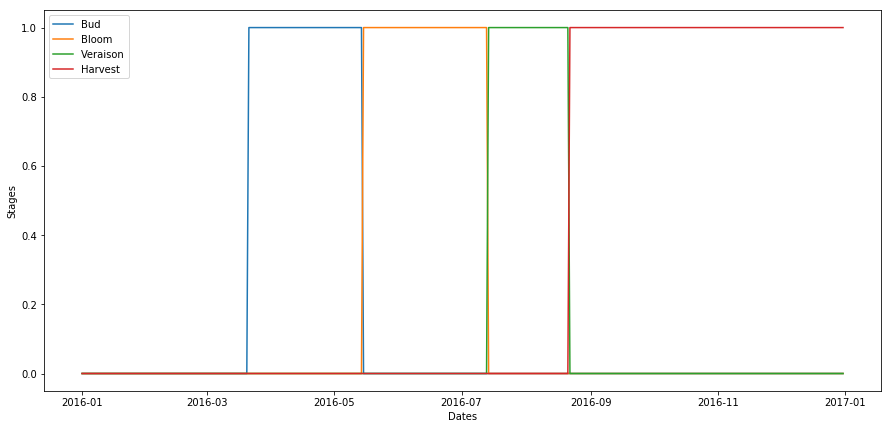

In [78]:
fig, ax = plt.subplots(figsize=(15,7))
fig = df[['Bud','Bloom',"Veraison", "Harvest"]].plot(ax=ax)

plt.xlabel("Dates")
plt.ylabel("Stages")

Text(0,0.5,'Temprature')

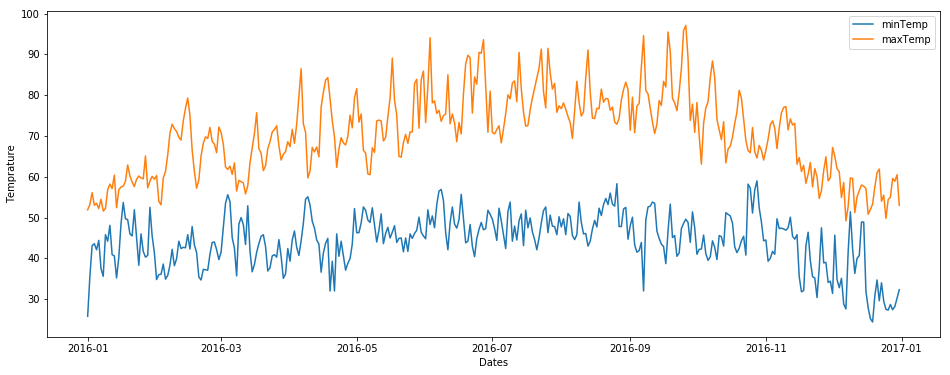

In [79]:
fig, ax = plt.subplots(figsize=(16,6))
fig = df[["minTemp", "maxTemp"]].plot(ax=ax)
plt.xlabel("Dates")
plt.ylabel("Temprature")

#### WORKING WITH TS

In [80]:
dataparse = lambda dates: pd.datetime.strptime(dates, "%Y-%m")
data = pd.read_csv('./data/AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dataparse)

In [81]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [82]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [83]:
ts = data['#Passengers']

In [84]:
# Converting to a saries
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [85]:
#1. Specific the index as a sting constant:
ts['1949-01-01']

#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(1949,1,1)]

112

In [86]:
ts["1949"]

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

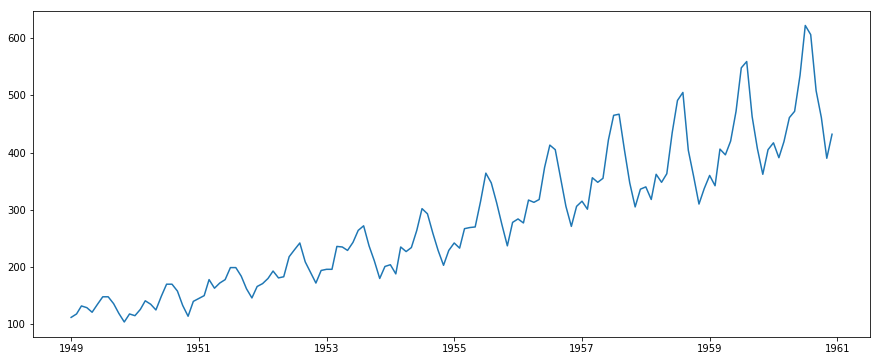

In [87]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.plot(ts)

In [90]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print("Results of Dicke-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

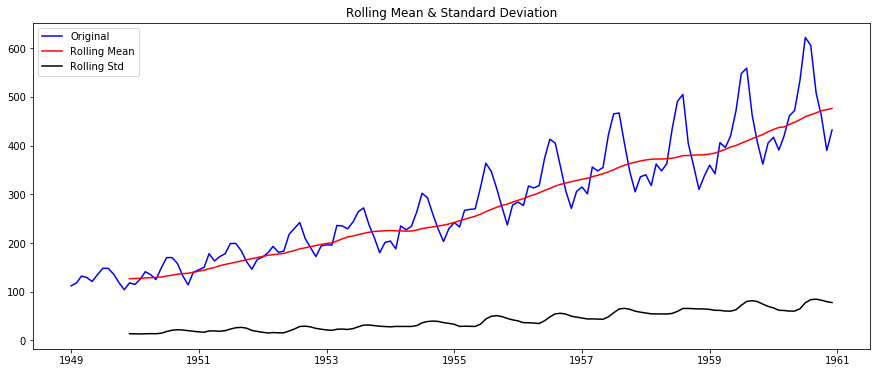

Results of Dicke-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [91]:
test_stationarity(ts)

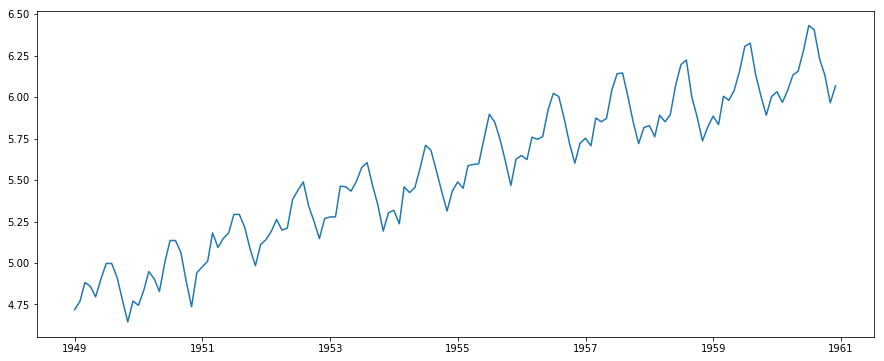

In [93]:
# Estimating and Eliminating Trend
ts_log = np.log(ts)
plt.plot(ts_log)

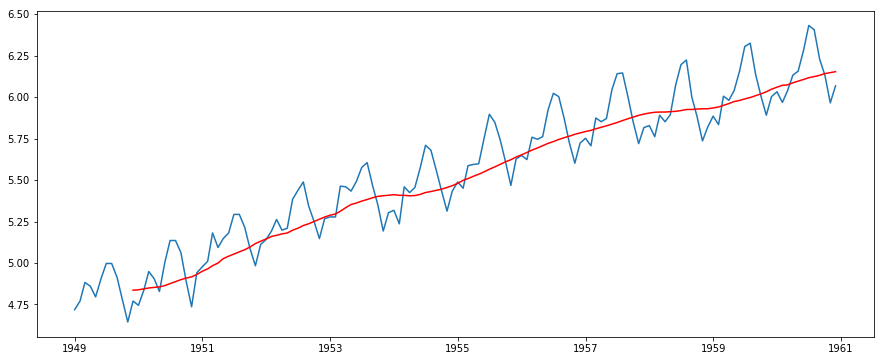

In [95]:
# Moving average
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [97]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

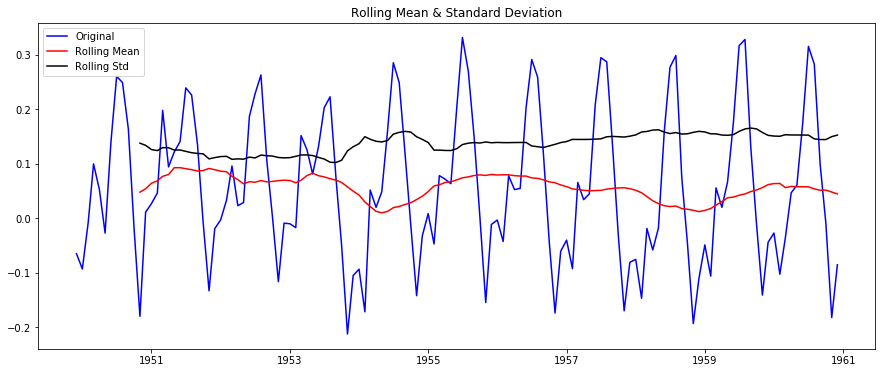

Results of Dicke-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [98]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Eliminating Trend and Seasonality


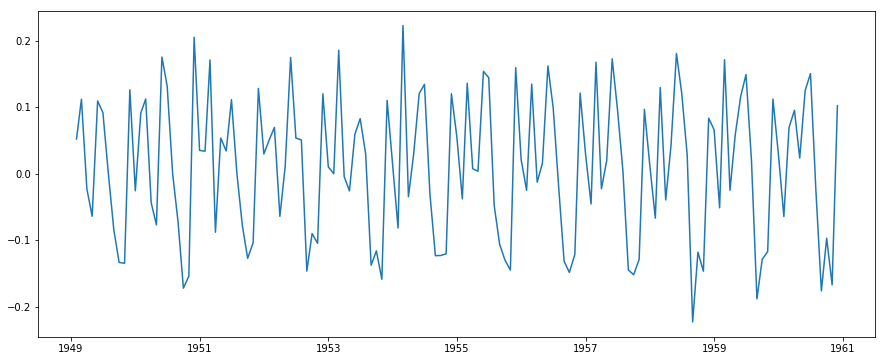

In [100]:
## Differencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

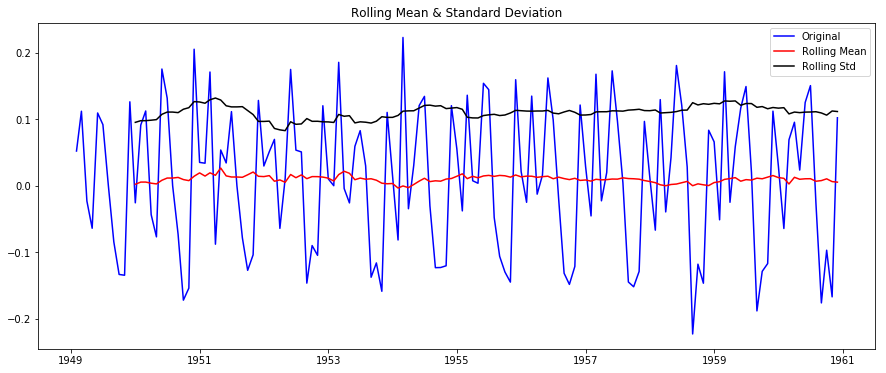

Results of Dicke-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [102]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

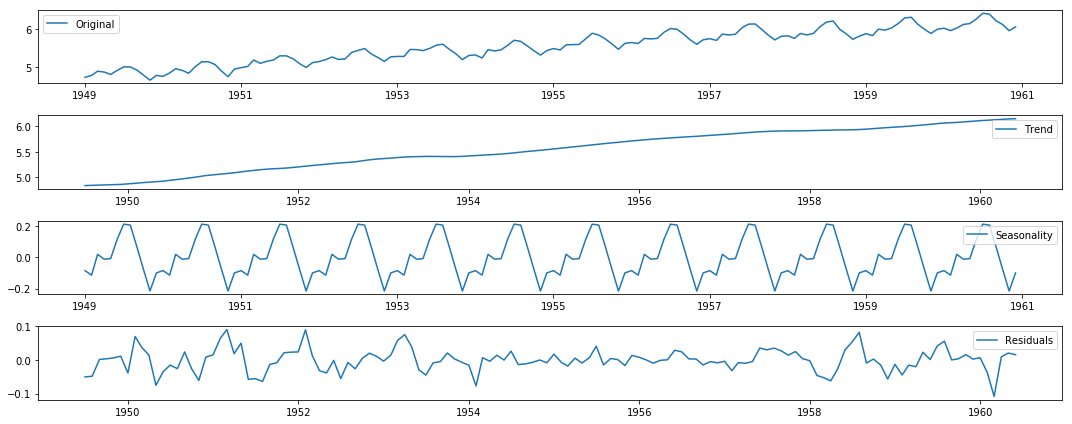

In [106]:
# Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

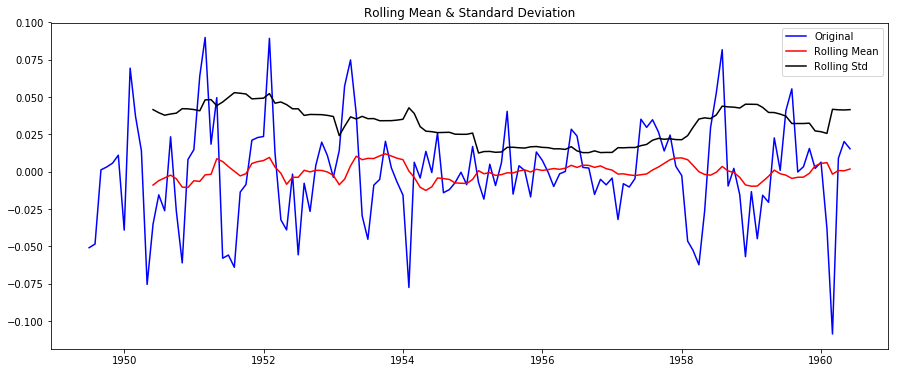

Results of Dicke-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [107]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

#### 5. Forecasting a Time Series

In [108]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [109]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

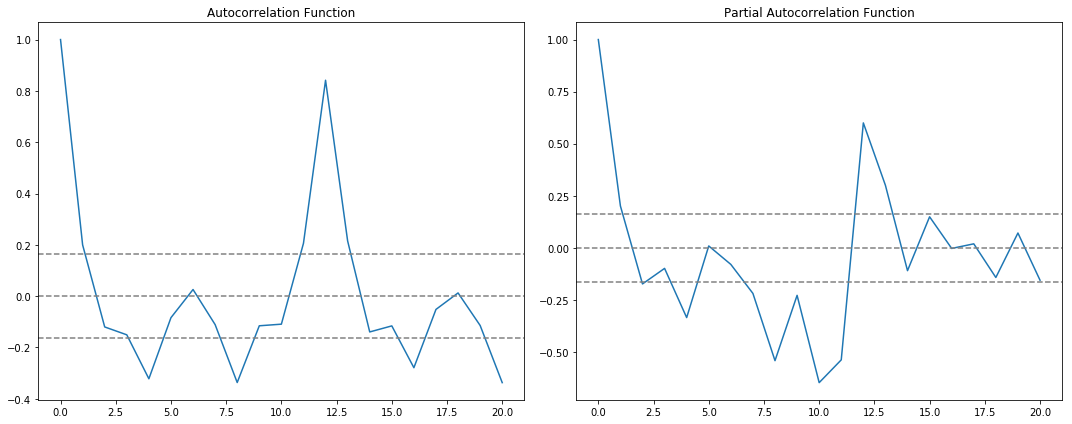

In [112]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#### AR Model

Text(0.5,1,'RSS: 1.5023')

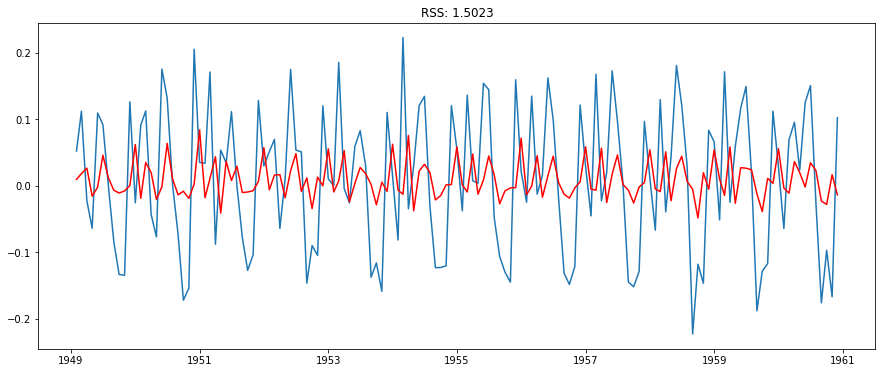

In [135]:
from statsmodels.tsa.arima_model import ARIMA

# the p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q)
model = ARIMA(ts_log, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' %sum((results_AR.fittedvalues-ts_log_diff)**2))

#### MA Model

Text(0.5,1,'RSS: 1.4721')

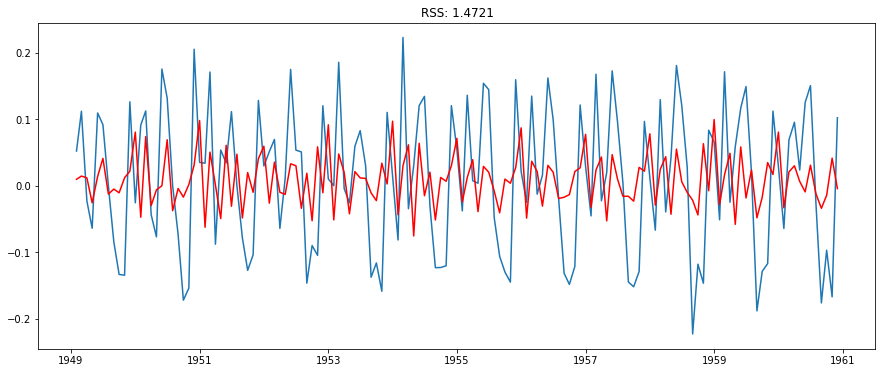

In [137]:
model = ARIMA(ts_log, order=(0, 1, 2))
results_MA = model.fit(disp=-11)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues-ts_log_diff)**2))

#### Combined Model

D:\Miniconda\envs\model\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Miniconda\envs\model\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Miniconda\envs\model\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


Text(0.5,1,'RSS: 1.0292')

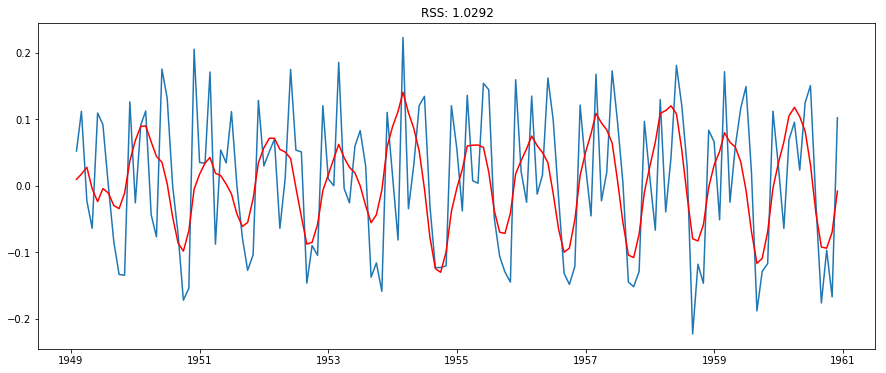

In [138]:
model = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [139]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [140]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [146]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5,1,'RMSE: 90.1040')

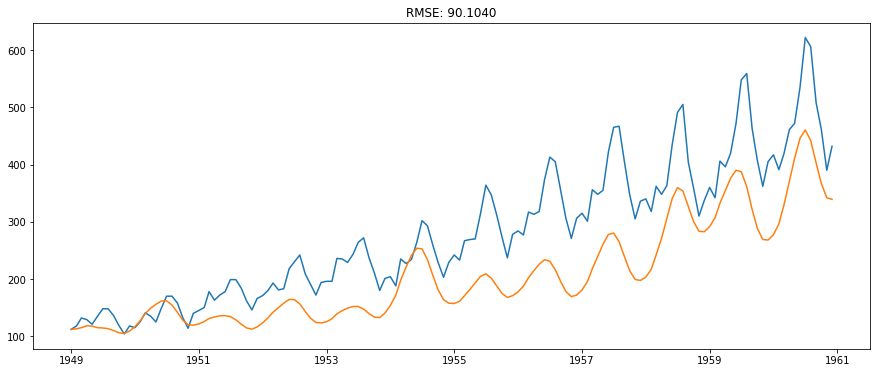

In [148]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA -ts)**2)/len(ts)))